### Datasets
Zajmiemy się przetawrzaniem zbioru glass dostępny do pobrania tutaj http://archive.ics.uci.edu/ml/datasets/glass+identification
Jest to real life zbior danych ktory zawiera informacje o typie szkła i ilosci mineralow ktore zawiera.
przykladowo takie i inne zbior tez jest na kagglu ale nie ma wiecej info

### Wczytanie danych
Rozpoczynamy od wczytania danych - mozemy do tego uzyc naszego utilla do wczytywania plikow typu arff

In [17]:
import os
from multi_imbalance.utils.data import preprocess_dataset
import numpy as np

np.random.seed(0)
dataset_name = 'glass'
dir=os.getcwd() # te sciezkie potem poprawie, jak bedzie po releasie i w innym miejscu notebook
X,y = preprocess_dataset(f'{dir}/../data/arff/{dataset_name}.arff') # preprocess jakkolwiek tu nie pasuje, lepsza nazwa funkcji? zmiana api
print(X[:5])
print(y[:5])

[[ 1.51793 12.79     3.5      1.12    73.03     0.64     8.77     0.
   0.     ]
 [ 1.51643 12.16     3.52     1.35    72.89     0.57     8.53     0.
   0.     ]
 [ 1.51793 13.21     3.48     1.41    72.64     0.59     8.43     0.
   0.     ]
 [ 1.51299 14.4      1.74     1.54    74.55     0.       7.59     0.
   0.     ]
 [ 1.53393 12.3      0.       1.      70.16     0.12    16.19     0.
   0.24   ]]
[0 5 0 4 1]


Zbior ten charakteryzuje się wieloklasowym niezbalansowaniem
Mozemy go sobie zwizualizowac, zbior ma wiele wymiarow, do zredukowania wymiarow do 2 uzywamy PCA
(chociaz nie wiem czy to pisac)

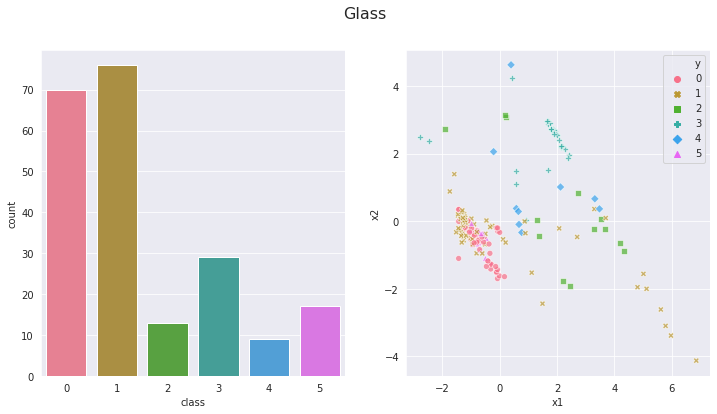

In [18]:
# TO sie wpakuje gdzies do funkcji, nie komentuj
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from multi_imbalance.utils.data import construct_flat_2pc_df

sns.set_style('darkgrid')

n = len(Counter(y).keys())
p = sns.color_palette("husl", n)

pca = PCA(n_components=2)
pca.fit(X)

fig, axs = plt.subplots(ncols=2)
fig.set_size_inches( 12, 6)
axs = axs.flatten()

axs[0].set_xlabel("class")
fig.suptitle("Glass", fontsize=16)

sns.countplot(y, ax=axs[0], palette=p)
X = pca.transform(X)
df = construct_flat_2pc_df(X, y)
sns.scatterplot(x='x1', y='x2', hue='y', style='y', data=df, alpha=0.7, ax=axs[1], legend='full', palette=p)

Widzimy, że zbiór jest niezbalansowany wieloklasowo, mamy dwie klasy ktore dominują 4 inne

### Przygotowanie danych do uczenia

W celu przygotowania danych do uczenia podzielimy zbior na dane uczace i testowe, nastepnie je znormalizujemy.
Uzyjemy w tym celu narzedzi dsotepnych w sklearn.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
normalizer = StandardScaler().fit(X_train)

X_train= normalizer.transform(X_train)
X_test = normalizer.transform(X_test)


### Uczenie
Teraz cos napsiac ze sie uczymy, jako baseline/podstawowy kalsyfikator uzyjmey drzewa dostepna w sklearn

In [20]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Do ewaluacji uzyjemy metryki gmean, cos powiedziec ze jest ona przeznacozna/dobra dla danych niezbalansowanych, bo
accuracy ssie (ale w filmie pominac w komentarzu bo bedzie we wstepie)

In [21]:
from imblearn.metrics import geometric_mean_score
gmean = geometric_mean_score(y_test, y_pred, correction=0.001)
f'Decision Tree: {round(gmean,3)}'

'Decision Tree: 0.082'

Widzimy, jest dramat i tu wchodzimy my!
### Resampling
Bierzemy SOUPa! SOUP to hybrydowa metoda preprocessingu danych, ktora wyznacza docelową licznosc klazzz a potem modyfikuje zbior danych tak aby osiagnac oczekiwane rozmiary klass

In [22]:
from multi_imbalance.resampling.soup import SOUP

soup = SOUP()
X_train_res, y_train_res = soup.fit_transform(X_train, y_train)

Powtarzamy obliczenia ale tym razem na zmodyfikowanych danych

In [23]:
clf = DecisionTreeClassifier()
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

gmean = geometric_mean_score(y_test, y_pred, correction=0.001)
f'Decision Tree + SOUP: {round(gmean,3)}'

'Decision Tree + SOUP: 0.192'

Mjut malina! Moze i 18% ale to 3 razy lepiej, dostroimy. Poza metodami preprocessingu dostepnymi w multi-imbalance
dostepne sa rowniez algorytmu do enseblingu?? danych.

### Ensemble
W naszym przypadku uzyjemy OVO. OVO jest metodą dekompozycji gdzie tworzymy pary kazdy z kazdym, tak trenujemy klasyfikatory ktore potem glosuja na decyzje. OVO w naszym pakiecie jest superasne bo mozemy wrzucac do niego dowolne klasfyikatory m.in z sklearna ktore implementuja odpowiednie metody (jakos tak ladnie to czeba) i tak samo z metodami resamplingu! Resampling dzieje się miedzy parami
( w sensie ze robimy pare i per para jest resampling za akzdym razem, to trzeba jakos zwiezle i ladnie i moze rozbic)
W naszym przykladzie do resamplingu uzyjemy soupa bo supcio dzialal

In [24]:
from multi_imbalance.ensemble.ovo import OVO

clf = OVO(
    binary_classifier='tree',
    preprocessing=SOUP()
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
gmean = geometric_mean_score(y_test, y_pred, correction=0.001)
f'OVO with DecisionTree and SOUP: {round(gmean,3)}'

'OVO with DecisionTree and SOUP: 0.072'